# Model Baio

## Methodology
1. Identify relevant data
2. Define (descriptive and meaningful) Model
3. Specify priors
4. Conduct Inference (and sanity check)
5. Posterior Predictive Check

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Identify Relevant Data

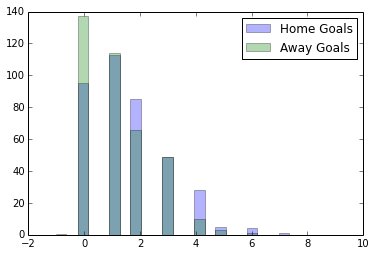

,team,logstart
0,Arsenal,0.521297
1,Chelsea,0.387766
2,Manchester United,0.610909
3,Liverpool,0.926762
4,Newcastle United,0.051293
5,Aston Villa,-0.111226
6,Fulham,-0.171850
7,Southampton,0.146603
8,Everton,0.191055
9,Tottenham Hotspur,0.274437


In [2]:
# Import season 2014/15 fixtures
# df = pd.read_csv('./data/s14-15.csv')
df = pd.read_csv('./data/s13-14.csv')

# Build team index
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

bins = np.linspace(-1, 10, 30)
plt.hist(observed_home_goals, bins, alpha=0.3, label='Home Goals')
plt.hist(observed_away_goals, bins, alpha=0.3, label='Away Goals')
plt.legend(loc='upper right')
plt.show()

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# Informed starting point (for what?) by using empirical log mean
# log mean score of each away and home team
# (From the perspective of the away team? - negative home log scores)
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

df = pd.DataFrame(teams['team'])
df['logstart'] = att_starting_points
df

## 2. - 3. Define Model & Specify Priors

In [3]:
with pm.Model() as model:    
    # global model parameters
    home        = pm.Normal('home',      0, .0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, .0001)

    # team-specific model parameters
    # TODO: why is mu not a random variable? Is it becasue we center data to
    # reduce uncertainty about the mean?
    atts_star   = pm.Normal("atts_star",
                           mu = 0,
                           tau = tau_att,
                           shape = num_teams)
    defs_star   = pm.Normal("defs_star",
                           mu = 0,
                           tau = tau_def,
                           shape = num_teams)

    # TODO: why center the data? => to make parameters interpretable. Otherwise, just
    # arbitrary estimates to fit the data
    atts        = pm.Deterministic('atts', atts_star - tt.mean(atts_star)) #identifieability
    defs        = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


## 4. Conduct Inference & Sanity Check

In [4]:
# Fit data, starting with the MAP
with model:    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(10000, step, start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 236.3 sec

array([[<matplotlib.axes.AxesSubplot object at 0x1272defd0>,
        <matplotlib.axes.AxesSubplot object at 0x1292c7f90>]], dtype=object)

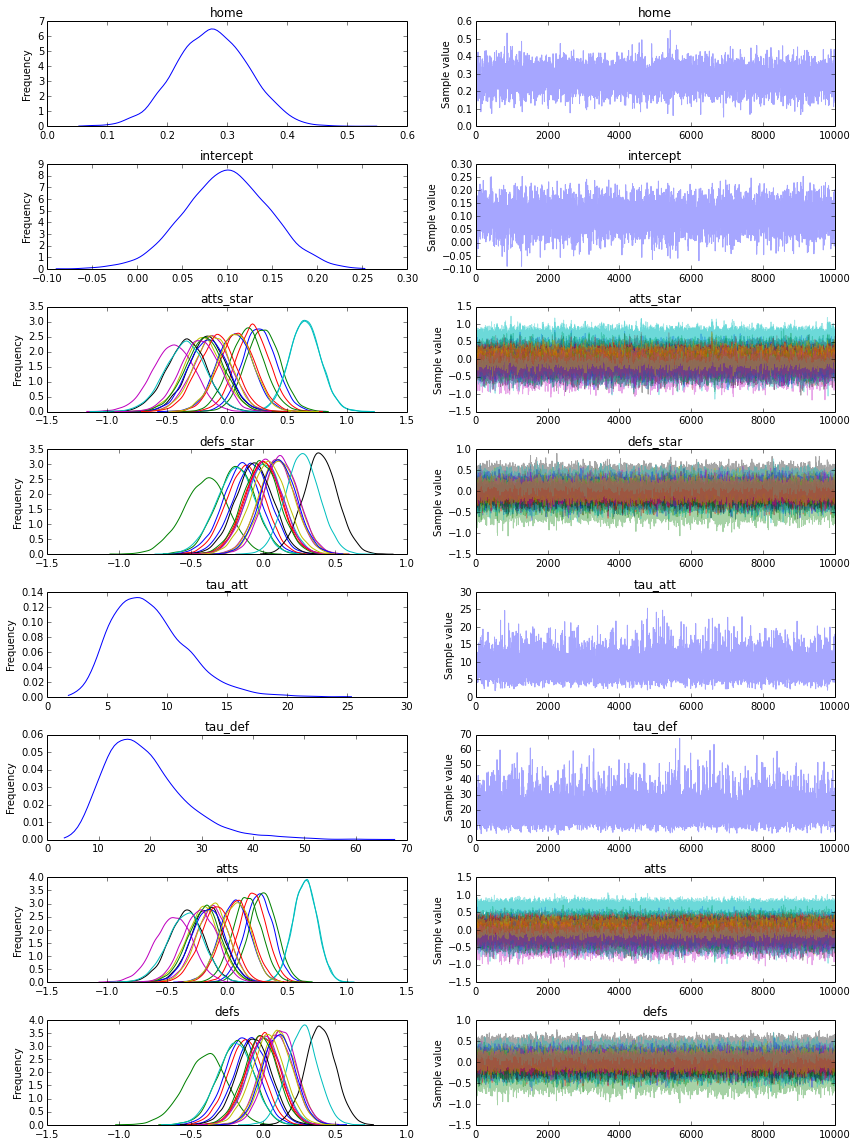

In [5]:
# Plot posteriors
pm.traceplot(trace)

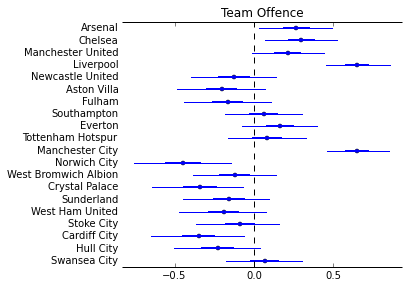

In [6]:
# Plot attack parameters
pm.forestplot(trace, varnames=['atts'], ylabels=df['team'].values, main="Team Offence")

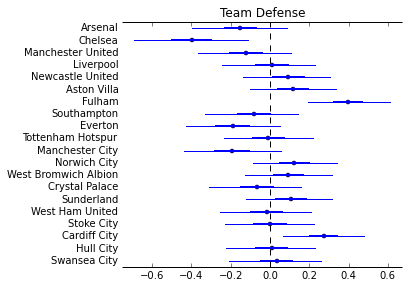

In [7]:
# Plot defense parameters
pm.forestplot(trace, varnames=['defs'], ylabels=df['team'].values, main="Team Defense")
# Negative scoring intensity is desired!

0.75


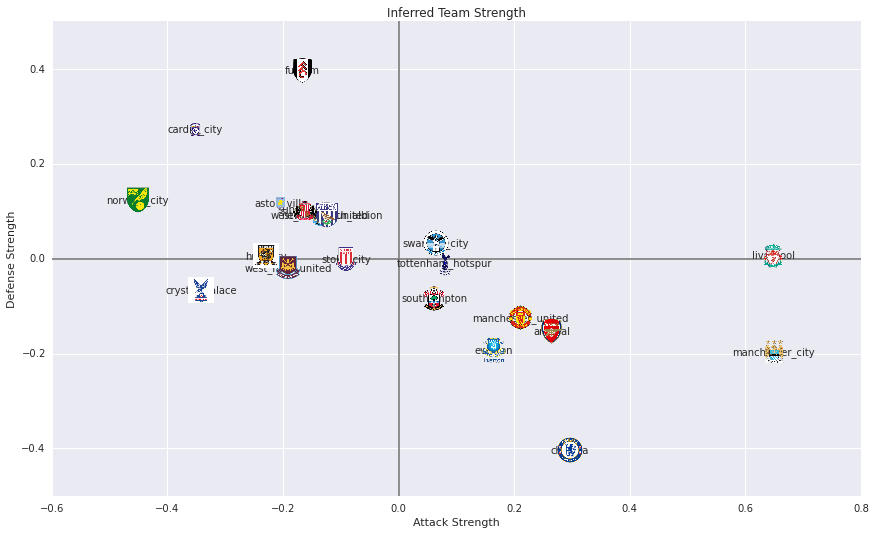

In [15]:
atts = trace['atts']
atts = np.swapaxes(atts,0,1)
mean_atts = [n.mean() for n in atts]

defs = trace['defs']
defs = np.swapaxes(defs,0,1)
mean_defs = [n.mean() for n in defs]

lv = pd.DataFrame(data=teams, columns=['team'])
lv['attack'] = mean_atts
lv['defense'] = mean_defs

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data

fig, ax = plt.subplots()
fig.set_size_inches(14.5, 8.5)

ax.scatter(lv['attack'], lv['defense'])

for k,v in enumerate(lv.values):
    x = lv.iloc[k]['attack']
    y = lv.iloc[k]['defense']
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    
    file = get_sample_data("/Users/moe/Desktop/epl-logos/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.1)
    
    ax.annotate(team, (x,y), ha="center", va="center", rotation=0, size=10)
    ab = AnnotationBbox(imagebox, (x,y), frameon=False)
    ax.add_artist(ab)

axes = plt.gca()
x_min = axes.get_xlim()[0]
x_max = axes.get_xlim()[1]
y_min = axes.get_ylim()[0]
y_max = axes.get_ylim()[1]

# ax.autoscale(False)
# extent = [-x_max,x_max, -y_max,y_max]
# arr1 = np.array([[1,0],[0,0]])
# ax.imshow(arr1, extent=extent, cmap=plt.cm.Reds, interpolation='none', alpha=.1)
# arr2 = np.array([[0,0],[0,1]])
# ax.imshow(arr2, extent=extent, cmap=plt.cm.Greens, interpolation='none', alpha=.1)


print(y_max - y_min / 2)

ax.axhline(0, color='grey')
ax.axvline(0, color='grey')
ax.grid(True)

ax.grid(True)

plt.title('Inferred Team Strength')
plt.xlabel('Attack Strength')
plt.ylabel('Defense Strength')

plt.draw()
plt.show()

## 5. Posterior Predictive Check

In [9]:
ppc = pm.sample_ppc(trace, samples=1, model=model, size=100)

In [77]:
print(ppc['away_points'].shape)
ppc['home_points']
observed_home_goals
observed_away_goals


(1, 100, 380)


array([0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 2, 1, 1,
       2, 3, 0, 2, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 2, 1, 1,
       1, 1, 1, 0, 1, 0, 3, 1, 0, 4, 2, 0, 0, 1, 3, 4, 2, 1, 1, 0, 3, 0, 1,
       0, 3, 2, 2, 0, 3, 1, 2, 2, 0, 2, 2, 2, 1, 3, 1, 0, 2, 4, 0, 1, 1, 3,
       3, 3, 3, 0, 0, 3, 3, 2, 4, 0, 1, 2, 4, 1, 0, 2, 2, 2, 2, 3, 1, 3, 0,
       3, 0, 0, 3, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 3, 2, 1, 1, 1, 0,
       3, 0, 0, 3, 1, 0, 0, 1, 1, 2, 1, 1, 2, 5, 1, 0, 1, 2, 0, 5, 0, 1, 0,
       1, 3, 0, 0, 0, 0, 3, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2,
       0, 0, 2, 3, 1, 3, 0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       3, 1, 0, 2, 1, 1, 1, 3, 3, 2, 0, 0, 0, 2, 3, 1, 2, 2, 0, 2, 3, 3, 0,
       4, 1, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 2, 3, 4, 2, 3, 1, 1, 1, 2, 1, 2,
       0, 0, 0, 0, 2, 0, 0, 2, 3, 3, 3, 2, 2, 3, 0, 0, 1, 3, 0, 3, 0, 3, 1,
       0, 1,

In [11]:
# for each of the 380 fixtures: 1 generated data set, containing 100 samples
ppc['away_points'].shape

(1, 100, 380)

In [78]:
# Calculate mean for every generated dataset
# for fix in range(0,380):
#     away_means = [n.mean() for n in ppc['away_points']]

away = ppc['away_points']
away = np.squeeze(away)
away = np.swapaxes(away,0,1)
# away_means = [n.mean() for n in away]

print(away.shape)

home = ppc['home_points']
home = np.squeeze(home)
home = np.swapaxes(home,0,1)
# away_means = [n.mean() for n in away]

print(home.shape)
type(home)

(380, 100)
(380, 100)


numpy.ndarray

In [13]:
# GOAL: Posterior for the marginal of the joint observation P(Y_0, Y1) (i.e. team 0 playing home and 1 playing away)
# We have the set of samples, which is representative for this posterior.
# Game 01 is game 1 from 380, hence at index 0
# print(np.where(home_team == 0))
# print(np.where(away_team == 1))

# [1] Marginalise over event likelihoods Win/Draw/Loss
# lets get the sample for the home observation variables Y0 and for Y1 (marginals)
margY0 = home[0]
margY1 = home[1]

#print(margY0.mean()) # Arsenal: slightly weaker offence but more significantly weaker defense then Chelsea
#print(margY1.mean()) # Chelsea

# Mean result prediction seems to make sense

# Now to calulate the probability of winning we define the events win/draw/loss as follows
# -> paper Louzada et al.

# [2] Goal Difference Likelihood for match 0 agains 1 (how does this relate to [1]?)
match_0_home = home[0]
match_0_away = away[1]

gd = [x[0]-x[1] for x in zip(match_0_home, match_0_away)]
from collections import Counter
freqs = Counter(gd).items()

rel_freqs = [(x[0],float(x[1])/100) for x in freqs]

win = [x[1] for x in rel_freqs if x[0] > 0]
loss = [x[1] for x in rel_freqs if x[0] < 0]
draw = [x[1] for x in rel_freqs if x[0] == 0]

print "Team 0 chances are: Win %f, Loss %f, Draw %f" %(sum(win), sum(loss), sum(draw))

Team 0 chances are: Win 0.460000, Loss 0.300000, Draw 0.240000


## Simulate Season 2014/2015

In [79]:
# Calculate goal differences
from collections import Counter

predictions = []

# Save odds for outcomes for each fixture
exp_win = np.empty(380,)
exp_draw = np.empty(380,)
exp_loss = np.empty(380,)
exp_events = np.chararray((380,)) # expected events
real_events = np.chararray((380,)) # Realised events
    
for g in range(num_games): # num_games
    g_home = home[g]
    g_away = away[g]
    g_home_team = home_team[g]
    g_away_team = away_team[g]
    home_teamname = teams['team'][g_home_team]
    away_teamname = teams['team'][g_away_team]    
    
    g_diff = [x[0] - x[1] for x in zip(g_home, g_away)]
    freqs = Counter(g_diff).items()

    rel_freqs = [(x[0],float(x[1])/100) for x in freqs]

    exp_win[g] = sum([x[1] for x in rel_freqs if x[0] > 0])
    exp_draw[g] = sum([x[1] for x in rel_freqs if x[0] == 0])
    exp_loss[g] = sum([x[1] for x in rel_freqs if x[0] < 0])
    
    results = [exp_win[g], exp_draw[g], exp_loss[g]] # 0 = win; 1 = draw; 2 = loss;
    event_mnemonics = ['Win', 'Draw', 'Loss']
    exp_events[g] = event_mnemonics[results.index(max(results))]
    
    actual_g_diff = observed_home_goals[g] - observed_away_goals[g]
    if (actual_g_diff > 0): real_events[g] = event_mnemonics[0]
    elif (actual_g_diff == 0): real_events[g] = event_mnemonics[1]
    else: real_events[g] = event_mnemonics[2]
    
    # Calculate overall accuracy (not too meaningful)
    if (actual_event == event):
        predictions.append(1)
    else:
        predictions.append(0)
            
#     if (g%38 == 0):
#         print "%s VS. %s: %s || %s" %(home_teamname, away_teamname, event, actual_event)
    
    # Group w.r.t. winning odds!
    # -> idea: i want 1000 times the same fixture to see if my 53% win forecast is true. since i don't hvae that
    #          i group all teams with similar odds and check then!
    
# float(sum(predictions))/num_games
exp_events
real_events

# Check if properly normalised
# What to do about precision??
(exp_loss + exp_win + exp_draw) == 1

## Calculate log-likelihood
# exp_* arrays contain the relative frequencies of the respective
# events from the simulated fixtures (100 samples each)
# We look at the actual realised fixture results in real_events
# and add the log-likelihood our model assigns this result for every individual outcome 
likelihood = np.empty(380,)

for g,event in enumerate(real_events):
    if (event == 'W'): likelihood[g] = exp_win[g]
    elif (event == 'D'): likelihood[g] = exp_draw[g]
    else: likelihood[g] = exp_loss[g]
        
ll = np.log(likelihood)

# Output log likelihood for total season 13/14
ll.sum()

-361.47207231316992

## Evaluate performance

In [28]:
## On season 14/15 itself
# Calculate event [Win/Draw/Loss] probabilities for each fixture in season
observed_home_goals.shape

(380,)

In [18]:
home[0]
away[0]

array([3, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 3, 3, 1, 2, 4, 0,
       1, 0, 1, 3, 2, 1, 2, 1, 1, 1, 4, 0, 3, 2, 1, 0, 1, 0, 0, 3, 3, 2, 1,
       4, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 5, 0, 1, 2, 1, 1, 0, 1, 2, 1, 3, 1,
       2, 0, 2, 2, 3, 1, 1, 2, 2, 2, 0, 1, 3, 1, 2, 1, 1, 0, 2, 2, 1, 1, 0,
       1, 3, 1, 0, 1, 1, 3, 2])